In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import sqlite3
import seaborn as sns
import numpy.polynomial.polynomial as poly

In [3]:
def duomenys():
    SDB = sqlite3.connect(r'C:\Users\pauli\Desktop\DataScienceNotebooks\DATA\WEBscr.db')
    Cs = SDB.cursor()
    sql="""SELECT * FROM TUrl;"""
    Cs.execute(sql)
    ans = Cs.fetchall()
    df1 = pd.read_sql_query(sql, con=SDB)

    df1['kaina']= df1['params'].apply(lambda x: str(x.split(';')[-1]))
    df1['kaina']= df1['kaina'].apply(lambda x: str(x.split('€')[0]).replace(' ','').replace('€',''))
    df1['kaina']= df1['kaina'].apply(lambda x: float(x))

    df1['metai']=df1['params'].apply(lambda x: str(x.split(';')[1]))
    df1['metai']=df1['metai'].apply(lambda x: int(x.split('-')[0]))

    df1['rida']=df1['params'].apply(lambda x: str(x.split(';')[-3]))

    SDB = sqlite3.connect(r'C:\Users\pauli\Desktop\DataScienceNotebooks\DATA\WEBscr.db')
    Cs = SDB.cursor()
    sql="""SELECT * FROM TAutos;"""
    Cs.execute(sql)
    ans = Cs.fetchall()
    df2 = pd.read_sql_query(sql, con=SDB)

    df1=df1[['id','kaina']]
    df= pd.merge(df2, df1, on='id', how='inner')

    df=df[['gamintojas', 'Pirma registracija', 'Kuro tipas', 'Pavarų dėžė', 'Rida', 'Defektai', 'kaina', 'Kėbulo tipas' ]]
    
    return df

def sutvarko_duomenis(df):

    df = df[df['Pirma registracija'].notna()]
    # df = df[df['Pavarų dėžė'].notna()]
    df = df[df['Rida'].notna()]
    df = df[df['Kėbulo tipas'].notna()]
    df = df[df['Defektai'].isna()]
    df= df[df['kaina'] <100000]
    df=df[['gamintojas', 'Pirma registracija', 'Kuro tipas', 'Pavarų dėžė', 'Rida', 'kaina', 'Kėbulo tipas' ]]

    df['Pirma registracija']= df['Pirma registracija'].apply(lambda x: float(str(x).split('-')[0]))
    df= df[df['Pirma registracija'] > 1990]

    df['Rida']= df['Rida'].apply(lambda x: float(str(x).replace(' ','').replace('km','')))
    df= df[df['Rida'] <500000]
    
    return df

def get_gamintojas(df):
    dftop = df.groupby('gamintojas').count()
    dftop = dftop.sort_values(by='kaina', ascending=False)
    dftop = dftop.head(7)
    top7 = dftop.index.to_list()
    df1=df[df['gamintojas'].isin(top7)]
    return df1

def get_kuras(df1, kuras):
    df1=df1[df1['Kuro tipas']==kuras]
    return df1

def get_pavaros(df1, pavaros):
    df1=df1[df1['Pavarų dėžė']==pavaros]
    return df1

def get_metai(df1, metai):
    df1 = df1[(df1['Pirma registracija'] ==metai)]
    return df1

def get_kebulas(df1, kebulas):
    df1=df1[df1['Kėbulo tipas']==kebulas]
    return df1

def kainos_ivertinimas(df1, rida):

    coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
    #!coefs are in decreasing order!↪
    B,A = coefs
    yfit = np.exp(A)*np.exp(B*rida)+1

    ats = round((yfit), 0)
    
    if ats <= 0:
        ats= 'Teks vežti į metalo laužą'
    
    return ats

df = duomenys()
df = sutvarko_duomenis(df)
df = get_gamintojas(df)

numatoma_kaina=[]
for index, row in df.iterrows():
    df1 = get_kuras(df, row['Kuro tipas'])
    if row['Kuro tipas'] != 'Elektra':
        df1 = get_pavaros(df1, row['Pavarų dėžė'])
    df1 = get_metai(df1, row['Pirma registracija'])
    df1= get_kebulas(df1, row['Kėbulo tipas'])
    rida= row['Rida']
    kaina = kainos_ivertinimas(df1, rida)
    numatoma_kaina.append(kaina)
    
df['numatoma_kaina']= numatoma_kaina

C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be poorly conditioned
  coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be poorly conditioned
  coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be poorly conditioned
  coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be poorly conditioned
  coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be poorly conditioned
  coefs = np.polyfit(x=df1['Rida'], y=np.log(df1['kaina']), deg=1)
C:\Users\pauli\AppData\Local\Temp\ipykernel_7864\3569497074.py:76: RankWarning: Polyfit may be 

In [11]:
df['proc']=round(((df['numatoma_kaina']/df['kaina']*100-100)**2)**(1/2), 0)

In [25]:
df= df.reset_index(drop=True)

In [26]:
df.head()

,gamintojas,Pirma registracija,Kuro tipas,Pavarų dėžė,Rida,kaina,Kėbulo tipas,numatoma_kaina,proc
0,Audi,2015.0,Benzinas,Automatinė,161500.0,10800.0,Sedanas,15961.0,48.0
1,Audi,2017.0,Dyzelinas,Automatinė,260000.0,15999.0,Universalas,14350.0,10.0
2,Audi,2013.0,Dyzelinas,Automatinė,337200.0,7450.0,Universalas,9068.0,22.0
3,Audi,2011.0,Dyzelinas,Automatinė,347000.0,12000.0,Universalas,6848.0,43.0
4,Audi,2019.0,Benzinas,Automatinė,87000.0,49500.0,Visureigis / Krosoveris,26513.0,46.0


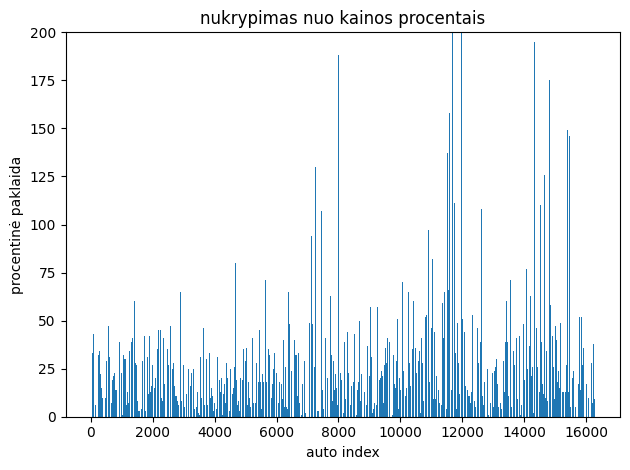

In [27]:
fig, axis = plt.subplots()

axis.bar(df.index, df['proc'])
axis.set_xlabel('auto index')
axis.set_ylabel('procentinė paklaida')
plt.title('nukrypimas nuo kainos procentais')
axis.set_ylim(top=200)
plt.tight_layout()
plt.show()

In [19]:
paklaidele=df['proc'].mean()
print(paklaidele)

28.008353295252135


In [24]:
print(len(df))

16281
